In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-01-17 01:33:51.589723


In [2]:
# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


# Setup

In [3]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-17 01:33:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-17 01:33:51 (61.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-01-17 01:33:58--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.207, 142.251.111.207, 142.251.167.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2024-01-17 01:33:58 (62.2 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [6]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
len(train_df), len(test_df)

(7613, 3263)

In [11]:
import random
random_index = random.randint(0, len(train_df)-5)  # dont go past the length and create random indexes
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target};", "(real disaster)" if target > 0 else "(not real disaster)", f"Text: {text}")

Target: 1; (real disaster) Text: Tennessee lesbian couple faked hate crime and destroyed own home with arsonÛ_ http://t.co/10mUEY8PXJ #Lesbian
Target: 0; (not real disaster) Text: Man Who Buried Dog Alive Thought No One Would Find Her But She Was Rescued Just In Time http://t.co/SahQ5UOAHW
Target: 0; (not real disaster) Text: #FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM
Target: 1; (real disaster) Text: The first piece of wreckage from the first-ever lost Boeing 777 which vanished back in early March along with the 239 people on board has
Target: 0; (not real disaster) Text: The one thing I like about here is thunder .. Heheh


In [211]:
from sklearn.model_selection import train_test_split

# Use train test split to split training data into training and validation data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
len(train_sentences), len(train_labels)

(6851, 6851)

In [14]:
len(val_sentences), len(val_labels)

(762, 762)

In [15]:
# lets check first 10
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [16]:
train_labels[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In NLP, there are two main concepts for turning text into numbers:

Tokenization - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:

  Using word-level tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.

Character-level tokenization, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.
Sub-word tokenization is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.

Embeddings - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:

Create your own embedding - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.

Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

In [17]:
train_sentences[1].split()

['Imagine', 'getting', 'flattened', 'by', 'Kurt', 'Zouma']

In [18]:
max_len = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_vocab_len = round(sum([len(i.split()) for i in train_sentences]))
max_vocab_len

102087

In [19]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorize_layer = TextVectorization(max_tokens = max_vocab_len,  # defines the number of words in the vocab.
                                    standardize = "lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams = None, # Create groups of n-words? no grouping
                                    output_mode = 'int',
                                    output_sequence_length = max_len,
                                    pad_to_max_tokens=True)

In [20]:
vectorize_layer.adapt(train_sentences)

In [21]:
random_sentence = random.choice(train_sentences)
print(f"Original: {random_sentence}")
print(f"Tokenized: {vectorize_layer(random_sentence)}")

Original: Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife
Tokenized: [ 546    9 1957   18 1305   28   21 1703    7 1029  181   33 1305  783
   12]


In [22]:
words_in_vocab = vectorize_layer.get_vocabulary()
top_10_words = words_in_vocab[:10]
last_5_words =  words_in_vocab[-5:]
top_10_words

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [23]:
last_5_words

['010217', '010156', '0025', '001116', '0011']

In [24]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_len, #set input shape
                             output_dim =  128,
                             input_length = max_len # how long for each input
                             )
embedding

In [25]:
random_sentence = random.choice(train_sentences)
print(f"Original: {random_sentence}")
print(f"Tokenized: {vectorize_layer(random_sentence)}")
print(f"Embedding: {embedding(vectorize_layer(random_sentence))}")

Original: #Cowboys: George: Injury woes took Claiborne from first round to trying to stick around; can he do it?:  http://t.co/12giQbVLYs
Tokenized: [ 5899  2449   345  6717  1166 18951    20    97  1604     5   563     5
  4536   470    71]
Embedding: [[-0.03386014 -0.04782869  0.0181937  ...  0.04634846 -0.0359746
  -0.03224666]
 [-0.03620882 -0.0246405  -0.0191347  ...  0.01979952  0.00833539
   0.03386397]
 [-0.02647195  0.03732945  0.03684114 ...  0.04832667  0.00645991
   0.01564592]
 ...
 [ 0.03244824 -0.02453949 -0.02923499 ...  0.02680774 -0.0416623
   0.04423347]
 [ 0.02481603  0.02594532  0.00229721 ... -0.02637091 -0.04127584
  -0.02362943]
 [-0.00946561 -0.00494354 -0.00407995 ... -0.03763976  0.03196711
   0.03453085]]


In [26]:
embedding(vectorize_layer(random_sentence)).shape

TensorShape([15, 128])

# TF-IDF encoder (baseline)
## Modeling 1-7

* Model 0: Naive Bayes (baseline)
* Model 1: Feed forward NN (Dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU Model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional NN (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning)
* Model 7: Same model as 6 but with 10% training data.

Use standard steps
1. Create a model
2. Compile
3. Fit
4. Evaluate
5 Fine tune


# Model 0: Baseline

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers
    ("clf", MultinomialNB()) # Model the text
])

# Fit the piupline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# Evaluate the baseline model

baseline_score = model_0.score(val_sentences, val_labels)
baseline_score

0.7926509186351706

In [29]:
baseline_pred = model_0.predict(val_sentences)
baseline_pred[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

# Evaluate Model functions

In [136]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# how should we evaluate our model?

# Function to evaluate: accuracy, precision, recall, f1-score


def evaluate_model(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [137]:
baseline_results = evaluate_model(val_labels, baseline_pred)

# Model 1

In [32]:
inputs = layers.Input(shape =(1,), dtype = tf.string)
x = vectorize_layer(inputs) # turn text into numbers
x= embedding(x) # creates an embedding of inputs
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [33]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = vectorize_layer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           13067136  
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13067265 (49.85 MB)
Trainable params: 1

In [35]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [36]:
import numpy as np

In [37]:

model_1.fit(x=train_sentences,
            y= train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 86s 384ms/step - loss: 0.6105 - accuracy: 0.6995 - val_loss: 0.5342 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 70s 325ms/step - loss: 0.4267 - accuracy: 0.8316 - val_loss: 0.4700 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 68s 318ms/step - loss: 0.3090 - accuracy: 0.8835 - val_loss: 0.4599 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 70s 327ms/step - loss: 0.2281 - accuracy: 0.9194 - val_loss: 0.4678 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 86s 400ms/step - loss: 0.1693 - accuracy: 0.9463 - val_loss: 0.4867 - val_accuracy: 0.7874


In [38]:
model_1_preds = model_1.predict(val_sentences)


24/24 [==============================] - 0s 3ms/step


In [39]:
model_1_preds.shape

(762, 1)

In [40]:
model_1_preds[1]

array([0.78562206], dtype=float32)

In [41]:
model_1_preds = np.round(model_1_preds)

In [42]:
model_1_preds[:10]

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [138]:
model_1_results = evaluate_model(val_labels, model_1_preds)

In [44]:
baseline_results= evaluate_model(val_labels, baseline_pred)

Precision: 0.886
Recall: 0.626
F1: 0.734


In [45]:
embed_weights = model_1.get_layer(name="embedding").get_weights()[0]

## These embedded weights can represent the text string we are providing
## Lets visualize these embbeded weights

In [46]:
import io
out_v = io.open('vector.tsv', 'w', encoding = 'utf-8')
out_m = io.open( 'metadata.tsv', 'w', encoding = 'utf-8')
for num, word in enumerate(words_in_vocab):
    if num == 0:
      continue
    vec = embed_weights[num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [47]:
# Download files from Colab to upload to project

# try:
#   from google.colab import files
#   files.download('vector.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

# Recurrent Nueral Networks (RNN's)
The premise of a RNN (for sequence data):
Use the representation of the previous word to predict the next word
Or use a previous input to aid the represenataion of the later.

Unreasonable effectiveness of RNN Andrej

MIT Sequence modelling lecture.

Chris Olah intro to LSTM

# Model 2 : LSTM

LSTM = Long short term memory
Our structure
Input (text) --> Tokenize --> Embedding --> Layers (RNN / Dense) --> Output ( Label Probability)*italicized text*

In [48]:
# Create the LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = vectorize_layer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(128)(x)
# print(x.shape)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_lstm")

In [49]:
model_2.compile(loss ="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")


In [50]:
history_2 =  model_2.fit(train_sentences,
                         train_labels,
                         epochs = 5,
                         validation_data = (val_sentences, val_labels),
                         )

Epoch 1/5
215/215 [==============================] - 78s 351ms/step - loss: 0.1259 - accuracy: 0.9585 - val_loss: 0.8046 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 75s 348ms/step - loss: 0.0644 - accuracy: 0.9766 - val_loss: 0.8964 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 75s 351ms/step - loss: 0.0461 - accuracy: 0.9851 - val_loss: 0.8839 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 78s 362ms/step - loss: 0.0396 - accuracy: 0.9870 - val_loss: 0.8622 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 74s 343ms/step - loss: 0.0295 - accuracy: 0.9889 - val_loss: 0.8086 - val_accuracy: 0.7664


In [51]:
model_2_predictions = model_2.predict(val_sentences)


24/24 [==============================] - 1s 19ms/step


In [52]:
model_2_predictions = np.round(model_2_predictions)


In [139]:
model_2_results= evaluate_model(val_labels, model_2_predictions)

# Model 3 GRU

In [54]:
# Model 3 using GRU
inputs = layers.Input(shape=(1,), dtype="string")
x=vectorize_layer(inputs)
x= embedding(x)
x = layers.GRU(64)(x)
x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs, name ="model_3_GRU")


In [55]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")


In [56]:
history_3 = model_3.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            )

Epoch 1/5
215/215 [==============================] - 76s 337ms/step - loss: 0.0905 - accuracy: 0.9688 - val_loss: 0.8931 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 70s 324ms/step - loss: 0.0303 - accuracy: 0.9883 - val_loss: 0.8720 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 90s 418ms/step - loss: 0.0214 - accuracy: 0.9917 - val_loss: 0.8735 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 74s 343ms/step - loss: 0.0181 - accuracy: 0.9926 - val_loss: 0.9770 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 73s 340ms/step - loss: 0.0189 - accuracy: 0.9912 - val_loss: 0.9319 - val_accuracy: 0.7690


In [57]:
model_3_results = model_3.predict(val_sentences)

24/24 [==============================] - 1s 7ms/step


In [58]:
model_3_results = np.round(model_3_results)

In [140]:
model_3_GRU = evaluate_model(val_labels, model_3_results)

In [60]:
model_3_results = model_3.predict(val_sentences)
model_3_results = tf.squeeze(tf.round(model_3_results))


24/24 [==============================] - 0s 6ms/step


In [128]:
model_3_GRU = evaluate_model(val_labels, model_3_results)

In [62]:
baseline_results

(0.8861788617886179, 0.6264367816091954, 0.734006734006734)

# Model 4 Bidirectional RNN

In [63]:
### Model 4: Bidirectional RNN
inputs = layers.Input(shape=(1,), dtype="string")
x = vectorize_layer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs= layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [64]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [65]:
history_4 = model_4.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            )

Epoch 1/5
215/215 [==============================] - 81s 355ms/step - loss: 0.0561 - accuracy: 0.9886 - val_loss: 0.9057 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 74s 343ms/step - loss: 0.0190 - accuracy: 0.9918 - val_loss: 1.0499 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 74s 346ms/step - loss: 0.0166 - accuracy: 0.9923 - val_loss: 1.0648 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 83s 388ms/step - loss: 0.0135 - accuracy: 0.9928 - val_loss: 1.0634 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 109s 504ms/step - loss: 0.0124 - accuracy: 0.9934 - val_loss: 1.2970 - val_accuracy: 0.7651


In [66]:
model_4_results = model_4.predict(val_sentences)
model_4_results = np.round(model_4_results)

24/24 [==============================] - 1s 7ms/step


In [141]:
model_4_bidirectional = evaluate_model(val_labels, model_4_results)

## Convolutional Neural Network for text instead og images.
CNN is usually 2D. height and width but text data is 1D.

Previously used Conv2D for image data but now we will use conv 1D

Input (text) --> Tokenization --> Embedding --> Layers (typically Conv1D + pooling.) --> output layer binary

#Model 5 CNN for TEXT

In [68]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test =  embedding(vectorize_layer(["hello my name is"]))
conv_1d = layers.Conv1D(filters = 32,
                        kernel_size = 5,
                        activation ="relu",
                        padding = "same")
conv_1d_out = conv_1d(embedding_test) # pass test embedding through Conv1D layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_out = max_pool(conv_1d_out) # Get the most important feature / with highest value

embedding_test.shape, conv_1d_out.shape, max_pool_out.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [69]:
### model 5 CNN
inputs = layers.Input(shape=(1,), dtype="string")
x = vectorize_layer(inputs)
x=embedding(x)
conv_1d = layers.Conv1D(filters =32,
                  kernel_size = 5,
                  activation ="relu",
                  padding ="same")
conv_1d_out = conv_1d(x)
max_pool = layers.GlobalMaxPooling1D()
max_pool_out = max_pool(conv_1d_out)
outputs = layers.Dense(1, activation="sigmoid")(max_pool_out)

model_5 = tf.keras.Model(inputs,outputs, name="model_5_CNN")

In [70]:
model_5.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")


In [71]:
model_5.fit(train_sentences,
            train_labels,
            epochs =5,
            validation_data =(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 73s 336ms/step - loss: 0.0697 - accuracy: 0.9857 - val_loss: 0.8137 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 71s 331ms/step - loss: 0.0218 - accuracy: 0.9912 - val_loss: 0.9686 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 71s 329ms/step - loss: 0.0190 - accuracy: 0.9920 - val_loss: 0.9895 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 72s 333ms/step - loss: 0.0172 - accuracy: 0.9921 - val_loss: 1.0159 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 72s 337ms/step - loss: 0.0171 - accuracy: 0.9927 - val_loss: 1.0393 - val_accuracy: 0.7690


In [72]:
model_5.summary()

Model: "model_5_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           13067136  
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 1)                 

In [75]:
model_5_results = model_5.predict(val_sentences)
model_5_results = np.round(model_5_results)


24/24 [==============================] - 0s 7ms/step


In [142]:
model_5_CNN = evaluate_model(val_labels, model_5_results)

# Model 6: Tensorflow hub pretrained model feature extractor

In [77]:
# example of pretrained embedding with ubniversal sentence encoder.
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")
embed_samples = embed(["well im happy right now and working on machine learning"])


In [78]:

print(embed_samples[0][:50])

tf.Tensor(
[ 0.01176705 -0.09837344 -0.02711103 -0.05185115 -0.03547019 -0.0525281
 -0.06748347 -0.01807359  0.04745061 -0.03479735 -0.05810025  0.03575403
  0.03238718  0.0103424  -0.03102798 -0.02606353 -0.03106127 -0.03517567
 -0.02974068 -0.08577351  0.03521683  0.0333402   0.03548263  0.04496264
  0.00109145  0.03662711  0.05314748  0.06051062 -0.03454508  0.01353022
  0.0472224   0.01435264 -0.00838022  0.0155004  -0.0308779   0.06029988
 -0.00406179 -0.01831374  0.00934341  0.06378065  0.06638398  0.01507145
 -0.04042322  0.05201102  0.03471584 -0.01157868 -0.06068672 -0.01897913
  0.00968958 -0.00323966], shape=(50,), dtype=float32)


In [79]:
embed_samples[0].shape

TensorShape([512])

In [80]:
import tensorflow as tf
import tensorflow.keras.layers as layers
# Create a keras layer using the pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        input_shape=[],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = "USE")

In [81]:
# Create model using Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")

],name ="model_6_USE")

In [82]:
model_6.compile(loss= "binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = "accuracy")

In [83]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256880129 (979.92 MB)
Trainable params: 82305 (321.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [84]:
model_6.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 7s 15ms/step - loss: 0.4676 - accuracy: 0.7894 - val_loss: 0.4288 - val_accuracy: 0.8150
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3929 - accuracy: 0.8297 - val_loss: 0.4234 - val_accuracy: 0.8189
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3633 - accuracy: 0.8450 - val_loss: 0.4246 - val_accuracy: 0.8228
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3321 - accuracy: 0.8602 - val_loss: 0.4287 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2812 - accuracy: 0.8870 - val_loss: 0.4679 - val_accuracy: 0.8084


In [151]:
model_6_results = model_6.predict(val_sentences)

24/24 [==============================] - 0s 12ms/step


In [152]:
import numpy as np
model_6_results = np.round(model_6_results)

In [153]:
model_6_USE = evaluate_model(val_labels, model_6_results)

In [88]:
baseline_results


(0.8861788617886179, 0.6264367816091954, 0.734006734006734)

# Model 7 TF Hub Pretrained USE but only 10% of the data.

Transfer Learning helps when we dont have large datasets
How our model performs on smaller datasets.

In [89]:
# Create subsets of 10% of the training datasets
# train_10 = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_10 = int(0.1*len(train_sentences))
train_sentences_10 = train_sentences[:train_10]
train_labels_10 = train_labels[:train_10]

In [90]:
len(train_sentences_10), len(train_labels_10), train_10

(685, 685, 685)

In [91]:
# Checks the number of labels in the updated training data
pd.Series(np.array(train_labels_10)).value_counts()

0    406
1    279
dtype: int64

In [92]:
# train_10['target'].value_counts()

In [93]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a pervious model from before, we can use tf.keras.models.clone_model() method.


In [94]:
# val_sentences, val_labels

model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss= "binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = "accuracy")

# fit the model
history_7 = model_7.fit(train_sentences_10,
                        train_labels_10,
                        epochs =5,
                        validation_data = (val_sentences,val_labels))

Epoch 1/5
22/22 [==============================] - 4s 49ms/step - loss: 0.6542 - accuracy: 0.6745 - val_loss: 0.6159 - val_accuracy: 0.6916
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5068 - accuracy: 0.8117 - val_loss: 0.4895 - val_accuracy: 0.7769
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.3876 - accuracy: 0.8365 - val_loss: 0.4892 - val_accuracy: 0.7927
Epoch 4/5
22/22 [==============================] - 1s 51ms/step - loss: 0.3190 - accuracy: 0.8730 - val_loss: 0.5153 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 39ms/step - loss: 0.2637 - accuracy: 0.8978 - val_loss: 0.5352 - val_accuracy: 0.7651


In [95]:
model_7_transfer = model_7.predict(val_sentences)

24/24 [==============================] - 1s 14ms/step


In [96]:
model_7_transfer = np.round(model_7_transfer)

In [149]:
model_7_transfer_results = evaluate_model(val_labels, model_7_transfer)

 Note dont leak the traning data. If models with 10% data out performs a model trained with 100% data then its best to trust the gut and find the errors.

# Compare all results

In [154]:
all_model_results = pd.DataFrame({"0_Baseline:": baseline_results,
                                  "1_SimpleDense:": model_1_results,
                                  "2_LSTM:": model_2_results,
                                  "3_GRU:": model_3_GRU,
                                  "4_Bidirectional:": model_4_bidirectional,
                                  "5_CNN:": model_5_CNN,
                                  "6_tf_hub_transfer:": model_6_USE,
                                  "7_tf_hub_10% :": model_7_transfer_results})

In [155]:
all_model_results = all_model_results.transpose()

<Axes: >

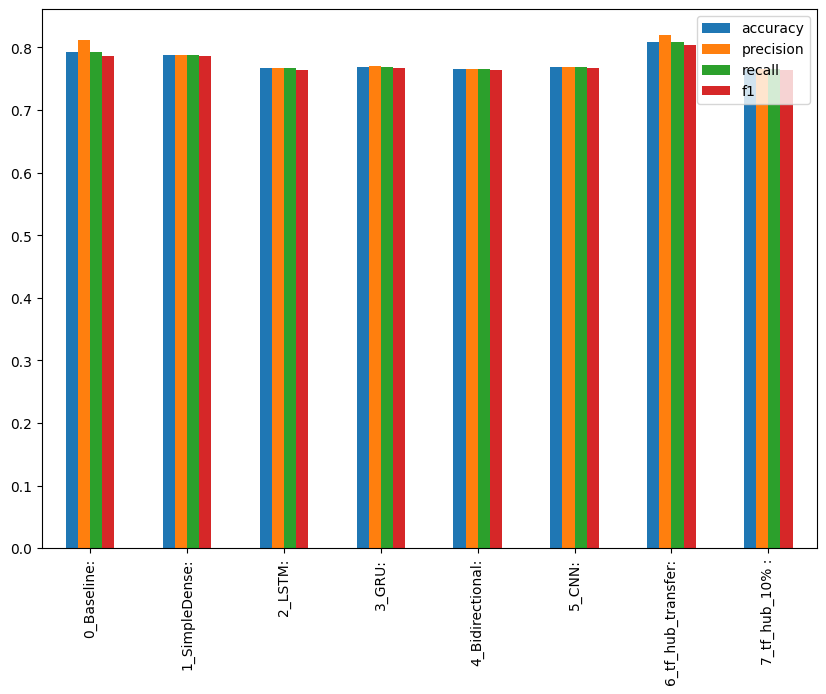

In [156]:
all_model_results.plot(kind ="bar", figsize=(10,7))

<Axes: >

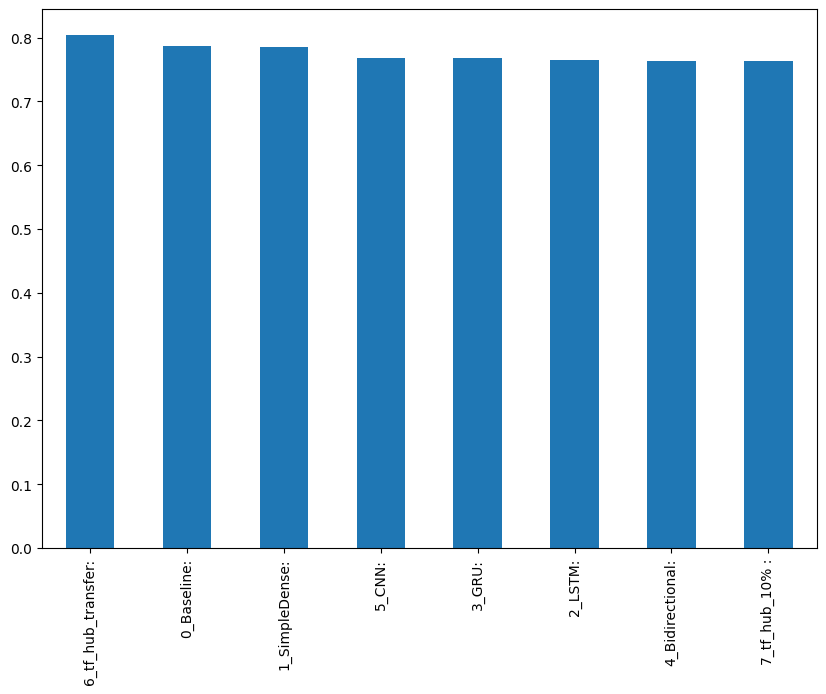

In [157]:
# Sort the models results to show F1
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize = (10,7))

In [158]:
model_6.save("tfhub_model_6")

In [159]:
loaded_model = tf.keras.models.load_model("tfhub_model_6")

In [160]:
loaded_model.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 20ms/step - loss: 0.4679 - accuracy: 0.8084


[0.46788597106933594, 0.808398962020874]

In [161]:
from google.colab import files
files.download("/content/tfhub_model_6")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [163]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256880129 (979.92 MB)
Trainable params: 82305 (321.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [196]:
# find the predictions with the highest prediction prob but the most incorrect.

model_6_preds = model_6.predict(val_sentences)

24/24 [==============================] - 1s 20ms/step


In [197]:
# preds_sort = np.sort(preds)
# preds_sort
model_6_pred_probs = tf.squeeze(tf.round(preds))


In [194]:
incorrect_preds = []
for i in range(len(preds)):

  if preds[i] != val_labels[i]:
    incorrect_preds.append(i)

In [226]:
model_6_predicts = []
for values in model_6_preds:
  model_6_predicts.append(values)

In [229]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_predicts,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,[0.052117396],0.0
1,FedEx no longer to transport bioterror germs i...,0,[0.45110708],0.0
2,Gunmen kill four in El Salvador bus attack: Su...,1,[0.9916283],1.0
3,@camilacabello97 Internally and externally scr...,1,[0.10476123],0.0
4,Radiation emergency #preparedness starts with ...,1,[0.6523524],1.0


In [231]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
381,Deaths 3 http://t.co/nApviyGKYK,0,[0.93138194],1.0
258,So this storm just came out of no where. .fuck...,1,[0.63603395],1.0
595,Panoramic Resources cuts jobs after seismic ev...,1,[0.95751816],1.0
266,http://t.co/vYmnRnSThG: U.S. in record hurrica...,1,[0.99249035],1.0
265,E1.1.2 Particulate=Break up of Solid Combust F...,1,[0.86920977],1.0
264,#BREAKING: there was a deadly motorcycle car a...,1,[0.92199636],1.0
263,4Yygb mhtw4fnet\n\nThousands evacuated as Taiw...,1,[0.9973339],1.0
597,TV program I saw said US air plane flew to ura...,1,[0.95817834],1.0
598,Truck crash on 40w at US70 in Lebanon is a fat...,1,[0.9979811],1.0
260,Some great footage of STRONG work from San Ber...,1,[0.9385648],1.0


In [232]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 0, Prob: 1.0
Text:
Deaths 3 http://t.co/nApviyGKYK

----

Target: 1, Pred: 0, Prob: 1.0
Text:
So this storm just came out of no where. .fuck me its cool

----

Target: 1, Pred: 0, Prob: 1.0
Text:
Panoramic Resources cuts jobs after seismic event http://t.co/mUwmfJGzYh

----

Target: 1, Pred: 0, Prob: 1.0
Text:
http://t.co/vYmnRnSThG: U.S. in record hurricane drought http://t.co/1mvSQG0XKE

----

Target: 1, Pred: 0, Prob: 1.0
Text:
E1.1.2 Particulate=Break up of Solid Combust Fossil Fuel Voltaic Active Forest Fire Biological VOC=Petroleum CH4 Bacteria Decomposition

----

Target: 1, Pred: 0, Prob: 1.0
Text:
#BREAKING: there was a deadly motorcycle car accident that happened to #Hagerstown today. I'll have more details at 5 @Your4State. #WHAG

----

Target: 1, Pred: 0, Prob: 1.0
Text:
4Yygb mhtw4fnet

Thousands evacuated as Taiwan prepares for strongest typhoon of 2015 - ABC Online

----

Target: 1, Pred: 0, Prob: 1.0
Text:
TV program I saw said US air plane flew to uran

In [233]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 0, Prob: 0.0
Text:
The devastation when you smash your phone ??????????????????????????

----

Target: 0, Pred: 0, Prob: 0.0
Text:
@pxnatosil @RenuncieDilma  Fatality!

----

Target: 0, Pred: 0, Prob: 0.0
Text:
Do you feel like you are sinking in unhappiness? Take the quiz: http://t.co/BTjPEO0Bto http://t.co/ClyJ32L333

----

Target: 0, Pred: 0, Prob: 0.0
Text:
Do Your Own Thing: The Battle of Internal vs External Motivation: http://t.co/w9P3hAuHEi

----

Target: 0, Pred: 0, Prob: 0.0
Text:
Damn Wale knows how to ruin a song??

----

Target: 0, Pred: 0, Prob: 0.0
Text:
@YahooSchwab easy way to look good after the Ray Rice fiasco...that blew up

----

Target: 0, Pred: 0, Prob: 0.0
Text:
Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) http://t.co/8j4rdwyjWu http://t.co/9MkZPZfKL2

----

Target: 0, Pred: 0, Prob: 0.0
Text:
The meaning I picked the one that changed my life: overcome fear behold wonder.

TCC catch the light... endless... http://t.co/eeRkH8lj

In [234]:
# Make predictions on the test dataset
test_sentences =  test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be a list
  pred= tf.round(pred_prob)
  print(f"Text: {test_sample}")
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")

1/1 [==============================] - 0s 64ms/step
Text: Criminals Who Hijack Lorries And Buses Arrested In Enugu (PHOTO) http://t.co/5cZ7eM9OTr
Pred: 1, Prob: 0.7891789078712463
1/1 [==============================] - 0s 59ms/step
Text: The goddess is said to be married to either Perk?nas (thunder god) or Praam_ius (manifestation of chief heavenly god Dievas).
Pred: 0, Prob: 0.026579922065138817
1/1 [==============================] - 0s 93ms/step
Text: @fouseyTUBE @zaynmalik I would collapse
Pred: 0, Prob: 0.357765793800354
1/1 [==============================] - 0s 77ms/step
Text: Wolverine Fire Update - Thursday August 6 - 9:00 Am

Incident: Wolverine Fire Wildfire
Released: 41 min. ago... http://t.co/8WDTTzpTXH
Pred: 0, Prob: 0.223244771361351
1/1 [==============================] - 0s 71ms/step
Text: Now Playing Desolation Wilderness by Kodak To Graph
Pred: 0, Prob: 0.21886099874973297
1/1 [==============================] - 0s 72ms/step
Text: #hot  Reddit's new content policy goes 

In [237]:
murf_tweet = "Lifes like a box of chocolates, make it your own choice"

In [238]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [239]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=murf_tweet)

1/1 [==============================] - 0s 46ms/step
Pred: 0.0 (not real disaster) Prob: 0.007963374257087708
Text:
Lifes like a box of chocolates, make it your own choice


In [240]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [241]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 287ms/step
Pred: 1.0 (real disaster) Prob: 0.9930756688117981
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [242]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 65ms/step
Pred: 1.0 (real disaster) Prob: 0.9910262227058411
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


In [243]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [245]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 13ms/step


(0.4969630239975231, 0.0006521824461909752)